<a href="https://colab.research.google.com/github/sobiness/Sentiment-Analysis-on-twitter-dataset_sobika/blob/main/Sentiment_Analysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentimental Analysis using twitter dataset, SVM

In [6]:
import re
import pickle
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, error_bad_lines=False,lineterminator='\n')
df.head(5)

<ipython-input-7-c55caadc5b1c>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, error_bad_lines=False,lineterminator='\n')


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Performing EDA**

In [8]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [9]:
print('length of data is', len(df))

length of data is 1600000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
np.sum(df.isnull().any(axis=1))

0

In [12]:
df['target'].unique()

array([0, 4])

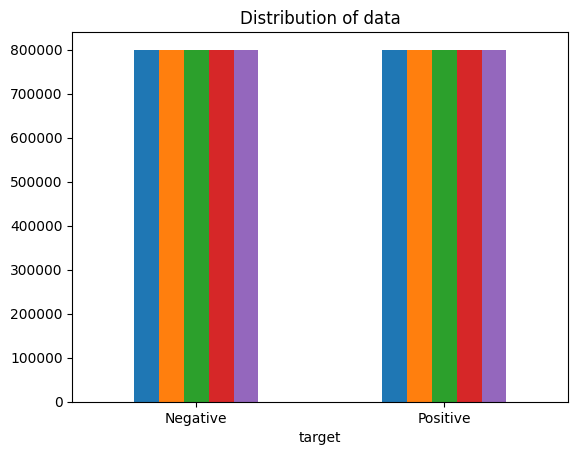

In [13]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

**Data Preprocessing**

In [14]:
data=df[['text','target']]


replacing 4(negative) with 1


In [15]:
data['target'] = data['target'].replace(4,1)

<ipython-input-15-54c9eb4fa536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [16]:
#separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [17]:
dataset = pd.concat([data_pos, data_neg])

In [18]:
#making all text to lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

Defining and removing stop words in the sentence


In [19]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [20]:
STOPWORDS = set(stopwordlist)

#function1
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

Removing punctuations

In [21]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

#function2
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

Removing more than 1 occurance of a letter

In [22]:
#function2
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

Removing URLS's

In [23]:
#function3
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

Tokenizing the Tweets

In [24]:
dataset['text'] = dataset['text'].astype(str)



In [25]:
dataset['text'] = dataset['text'].fillna('')


Tokenization of tweets

In [26]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()


800000            [love, health4uandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                   [lovesbrooklyn2, effect, everyone]
Name: text, dtype: object

Apply Stemming

In [27]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000            [love, health4uandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                   [lovesbrooklyn2, effect, everyone]
Name: text, dtype: object

Applying Lemmatizer

In [28]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


800000            [love, health4uandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                   [lovesbrooklyn2, effect, everyone]
Name: text, dtype: object

In [29]:
X=data.text
y=data.target

Traing and Testing Data

In [30]:
# Separating the 75% data for training data and 25% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =26105111)

Transforming the Dataset

In [31]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [32]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

Model evaluation

In [33]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


Support Vector Machine

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    199983
           1       0.81      0.82      0.82    200017

    accuracy                           0.81    400000
   macro avg       0.81      0.81      0.81    400000
weighted avg       0.81      0.81      0.81    400000



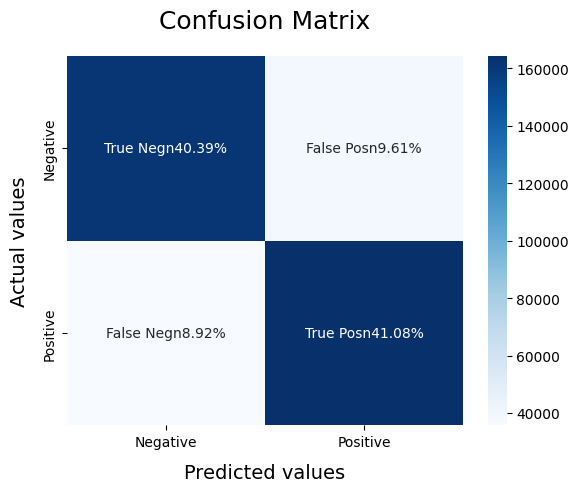

In [48]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

**TESTING THE SVM MODEL**

In [54]:
# Example sentence to test
example_sentence = "I do not like you"

preprocessed_sentence = cleaning_stopwords(example_sentence)
preprocessed_sentence = cleaning_punctuations(preprocessed_sentence)
preprocessed_sentence = cleaning_repeating_char(preprocessed_sentence)
preprocessed_sentence = cleaning_URLs(preprocessed_sentence)
preprocessed_sentence = stemming_on_text(preprocessed_sentence)
preprocessed_sentence = lemmatizer_on_text(preprocessed_sentence)


# Vectorize the preprocessed sentence
example_vec = vectoriser.transform([preprocessed_sentence])

# Make predictions
prediction = SVCmodel.predict(example_vec)
print(prediction)
sentiment = prediction[0]

# Interpret the prediction
if prediction == 1:
    sentiment = 'Positive'
elif prediction == 0:
    sentiment = 'Negative'
else:
    sentiment = 'Neutral'

print("Example Sentence: ", example_sentence)
print("Predicted Sentiment: ", sentiment)


[0]
Example Sentence:  I do not like you
Predicted Sentiment:  Negative


              precision    recall  f1-score   support

           0       0.83      0.82      0.82    199983
           1       0.82      0.83      0.83    200017

    accuracy                           0.82    400000
   macro avg       0.82      0.82      0.82    400000
weighted avg       0.82      0.82      0.82    400000



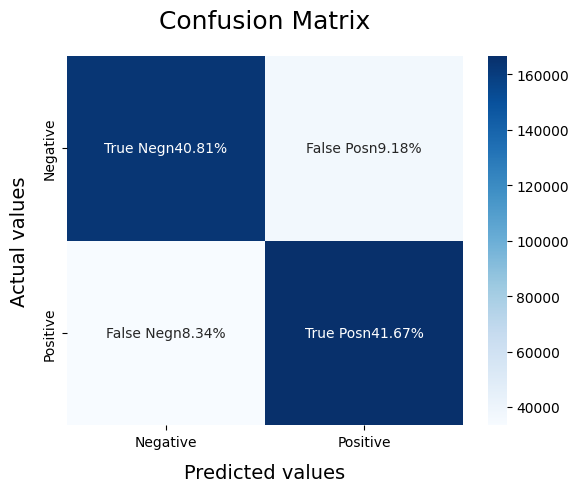

In [35]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

TESTING USING ROBERTA

In [ ]:
!pip install scikit-learn
!pip install transformers
!pip install scipy


In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
tweet = '@switchfoot http://twitpic.com/2y1zl - Awww, thats a bummer.  You shoulda got David Carr of Third Day to do it. ;D'

# pre-process tweet and get rid of any @mention and url http
tweet_words = []

for word in tweet.split(' '):
    if word.startswith('@') and len(word) > 1:
        word = '@user'

    elif word.startswith('http'):
        word = "http"
    tweet_words.append(word)

tweet_proc = " ".join(tweet_words)
print(tweet_proc)

@user http - Awww, thats a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [44]:
# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']
encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
print(encoded_tweet)

{'input_ids': tensor([[    0,  1039, 12105,  2054,   111,    83,  1401,     6, 45365,    10,
           741, 22539,     4,  1437,   370,   197,   102,   300,   871,  8902,
             9,  7470,  1053,     7,   109,    24,     4, 25606,   495,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}


In [45]:
# sentiment analysis
# output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
output = model(**encoded_tweet)

scores = output[0][0].detach().numpy()
scores = softmax(scores)

for i in range(len(scores)):

    l = labels[i]
    s = scores[i]
    print(l,s)

Negative 0.65822434
Neutral 0.28978804
Positive 0.051987663
